### Bedtools Post Hoc Analysis

In [74]:
# librariesss
import pandas as pd
import math
import scipy
import numpy as np
import pyranges as pr
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [75]:
# load in csv identifying individuals, set directory etc
hg_pop = pd.read_csv('igsr_samples.csv')  
d = pd.DataFrame()
dir = '/home/oona/nsf_grfp/all_bed/intersect'

In [76]:
# for each file in intersection directory, count the number of ancestry groups per segment and add all to dataframe with HGNum IDs
for bed_file in os.listdir(dir):
    filename = os.path.join(dir, bed_file)
    intersect = pr.read_bed(filename, as_df=True)
    switch_cnt = intersect.groupby(['Name'])['ThickEnd'].count().reset_index(name='count')
    # merged_df = pd.merge(intersect, switch_cnt, on=['Name', 'Name'], how='inner')
    switch_cnt['HGNum'] = os.path.basename(filename)
    d = pd.concat([d, switch_cnt])

In [77]:
# replace the _intersect.bed part of the file ID with nothing, only include rows w/switch count greater than one, compress file and save for reference
d['HGNum'] = d['HGNum'].str.replace('_intersect.bed', '', regex=True)
d = d[d['count'] > 1]
d.to_csv('switch_counts.zip', compression='gzip')

In [81]:
# merge 1000 Genomes identifier csv w/switch count csv we just made to get nationalities, etc for plots
hg_total = pd.merge(d, hg_pop, left_on='HGNum', right_on='Sample name')

In [107]:
# get number of individuals we have overall and per population code (about 10 the bedtools intersection analysis didn't work)
total_num_individuals = hg_total['HGNum'].nunique()
hg_total.groupby(['Population code'])['HGNum'].count()

Population code
ACB    1034707
ASW     303135
CLM     449221
MXL     174910
PEL     283660
PUR     564236
Name: HGNum, dtype: int64

In [111]:
# get approximate counts by dividing by number of individuals and rounding for now
population_counts = hg_total.groupby(['Population code'])['count'].sum().reset_index(name='count')
population_counts['count'] = round(population_counts['count'] / 504)

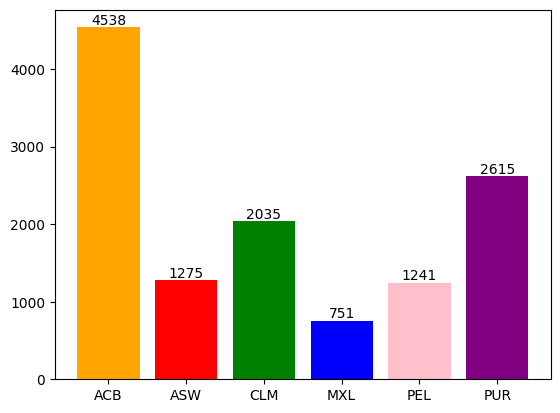

In [129]:
fig, ax = plt.subplots()
my_colors = ['orange', 'red', 'green', 'blue', 'pink', 'purple']
bars = ax.bar(population_counts['Population code'], population_counts['count'], color= my_colors)
# adds counts to top of bar
ax.bar_label(bars) 
plt.savefig("/home/oona/nsf_grfp/figs/seaborn_switch_plot.png")